In [16]:
import pandas as pd
import re
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [17]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("fyodor_m_d1821", "fyredoor4")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")
data["user"] = data["user"].replace("Wirelesss_", "W1r3lesss")
data["user"] = data["user"].replace("treklul", "trek44_")
data["user"] = data["user"].replace("ttrek_", "trek44_")
data["user"] = data["user"].replace("TriplesingleJ", "TripleSingleJames")
data["user"] = data["user"].replace("uuccugr", "uwu_cougar")


In [18]:
# Extract all unique users from the other streams as a reference
reference_users = set(data[data["stream"] != 302]["user"].unique())

# Extract users from stream 302
stream_302_users = data[data["stream"] == 302]["user"]

# Create a mapping of lowercase to correct capitalization using the reference data
user_mapping = {user.lower(): user for user in reference_users}

# Fix capitalization for users in stream 302
fixed_users = stream_302_users.apply(lambda x: user_mapping.get(x.lower(), x))

# Count how many users needed to be fixed
fix_count = (stream_302_users != fixed_users).sum()

# Update the data with fixed users
data.loc[data["stream"] == 302, "user"] = fixed_users

In [19]:
# Find the first stream where each user sent a message
first_stream_df = data.groupby("user")["stream"].min().reset_index()
first_stream_df.rename(columns={"stream": "first_stream"}, inplace=True)

In [20]:
# Merge with the original DataFrame
data = data.merge(first_stream_df, on="user", how="left")
data.tail(10)

,date,user,message,stream,first_stream
1667088,2025-04-27 19:28:17 UTC,JBIN2036,OOOO,303,120
1667089,2025-04-27 19:28:17 UTC,JellyBelly__x,NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,303,273
1667090,2025-04-27 19:28:17 UTC,S_Face,speed4,303,237
1667091,2025-04-27 19:28:20 UTC,trek44_,AwHellNah,303,100
1667092,2025-04-27 19:28:20 UTC,berkinnn_,bye,303,277
1667093,2025-04-27 19:28:20 UTC,ifanbenmezda,bye,303,67
1667094,2025-04-27 19:28:21 UTC,Zoriemi,sammwyOa 󠀀,303,151
1667095,2025-04-27 19:28:21 UTC,10kerrr,bb,303,300
1667096,2025-04-27 19:28:22 UTC,inrro,bye 󠀀,303,270
1667097,2025-04-27 19:28:23 UTC,trek44_,aga,303,100


In [21]:
# Count occurrences of first_stream for each stream
pivot_table = data.groupby(["stream", "first_stream"]).size().unstack(fill_value=0)

# Reset index for better readability
pivot_table = pivot_table.reset_index()

In [22]:
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Columns: 305 entries, stream to 303
dtypes: int64(305)
memory usage: 724.5 KB


In [23]:
pivot_table = pivot_table.drop(columns=['stream'])

In [24]:
pivot_table

first_stream,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,300,301,302,303
0,1985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2105,941,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2150,204,400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1788,87,103,397,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1842,87,102,80,344,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,1009,196,29,0,18,73,14,218,0,70,...,193,49,30,66,362,758,0,0,0,0
300,747,90,55,11,4,248,0,54,0,67,...,51,8,61,49,57,53,731,0,0,0
301,1078,100,27,3,25,29,46,103,0,61,...,46,54,73,157,79,31,161,555,0,0
302,666,18,3,3,5,0,5,3,0,72,...,26,28,18,34,69,15,34,161,789,0


In [25]:
# Convert 'date' to datetime format and extract the month for color mapping
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month

# Get the month for each stream
stream_months = data.groupby('stream')['month'].first()

# Get the month for each stream
stream_months = data.groupby("stream")["month"].first()

# Define base colors for each month
base_color_map = {
    1: '#008B8B',  # Dark Cyan
    2: '#FF8C00',  # Dark Orange
    3: '#006400',  # Dark Green
    4: '#8B0000',  # Dark Red
    5: '#450145',  # Dark Purple
    6: '#00008B',  # Dark Blue
    7: '#808000',  # Olive
    8: '#006400',  # Dark Green
    9: '#8B4513',  # SaddleBrown
    10: '#a10202',  # Deep Red
    11: '#242323',  # Dark Gray
    12: '#730049'  # Dark Magenta
}

# Function to generate shades for each month color
def generate_shades(base_color, n_shades, lightness_factor=0.7):
    color = mcolors.to_rgba(base_color)
    light_color = [1 - (1 - c) * (1 - lightness_factor) for c in color]  # Generate a lighter color
    cmap = mcolors.LinearSegmentedColormap.from_list(
        f'shades_of_{base_color}', [color, light_color], N=n_shades)
    return [cmap(i) for i in range(n_shades)]

# Create a color mapping for each stream based on the month
color_list = []
for month in stream_months.unique():
    month_streams = stream_months[stream_months == month].index
    n_streams_in_month = len(month_streams)
    base_color = base_color_map.get(month, "#808080")  # Default gray if month is missing

    # Generate shades
    shades = generate_shades(base_color, n_streams_in_month) if n_streams_in_month > 1 else [base_color]

    # Assign shades to streams
    for i, stream in enumerate(month_streams):
        color_list.append((stream, shades[i]))

# Convert to dictionary for easy lookup
color_dict = dict(color_list)

# Ensure colors match pivot table index
sorted_color_list = [color_dict[stream] for stream in pivot_table.index]

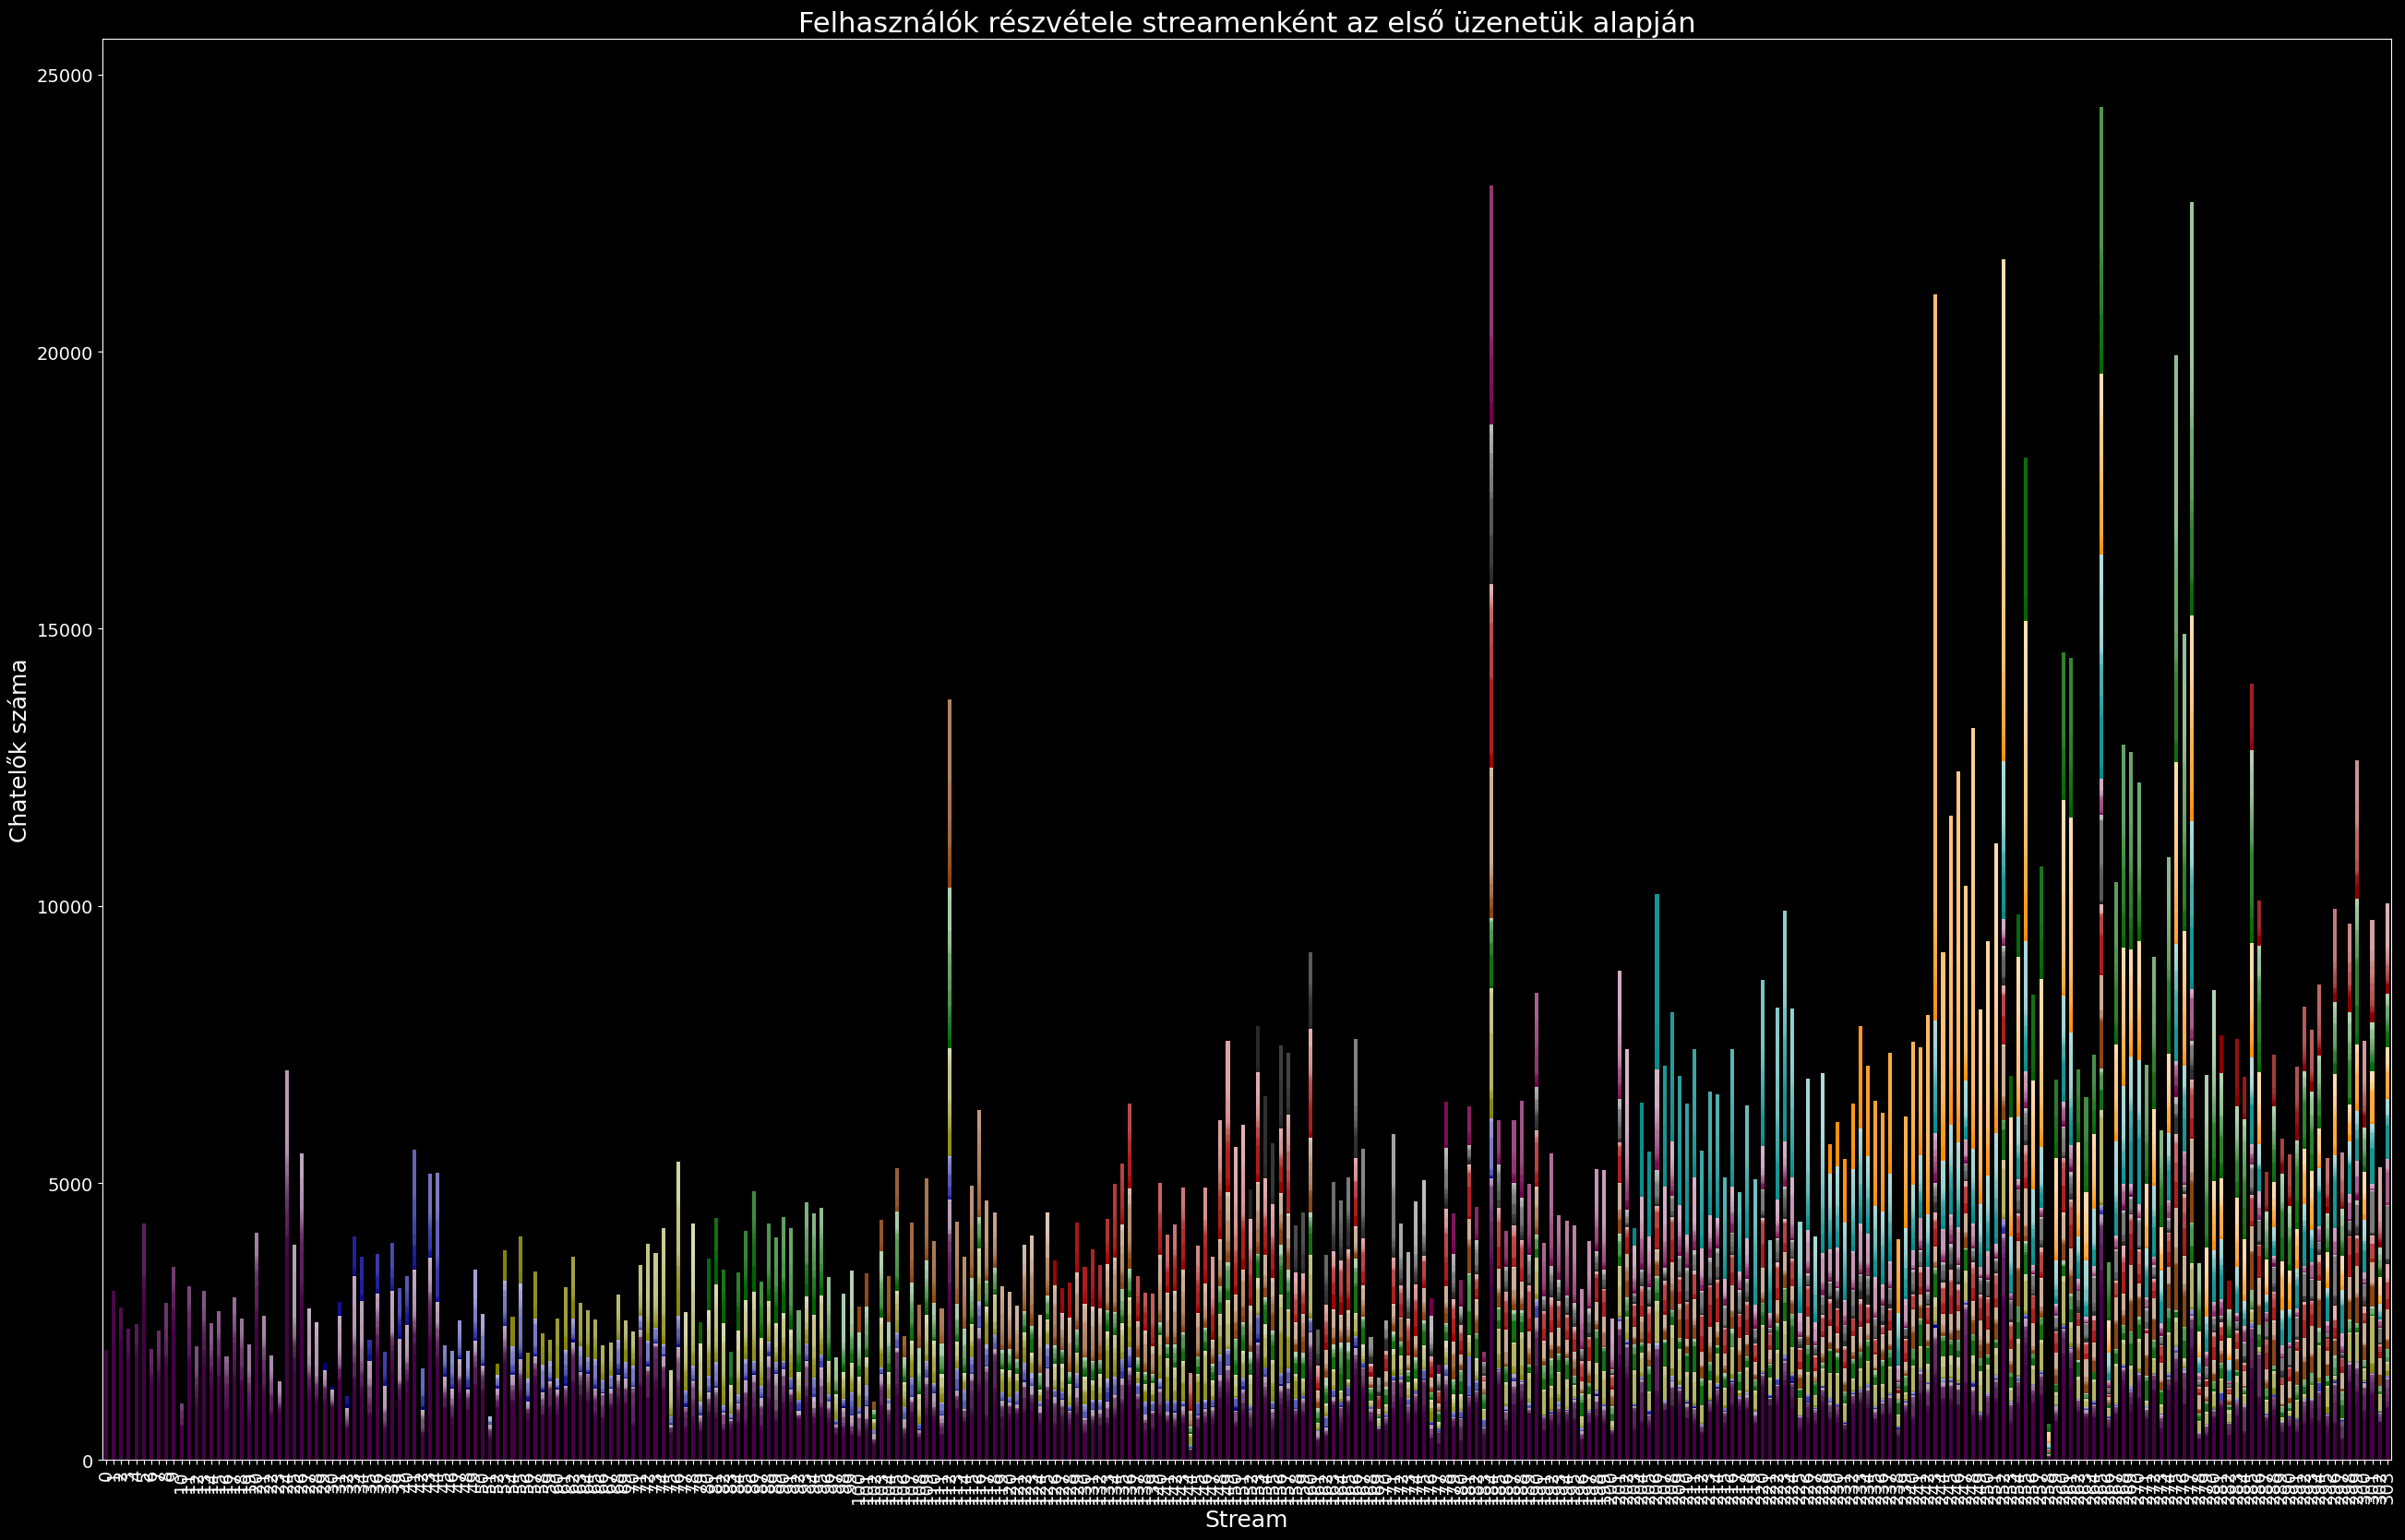

In [26]:
# Plot stacked bar chart
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(32, 20))

pivot_table.plot(kind='bar', stacked=True, ax=ax, color=sorted_color_list, legend=False)

plt.title('Felhasználók részvétele streamenként az első üzenetük alapján', fontsize=22)
plt.xlabel('Stream', fontsize=18)
plt.ylabel('Chatelők száma', fontsize=18)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [27]:
# Convert pivot table values to percentages (row-wise normalization)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100


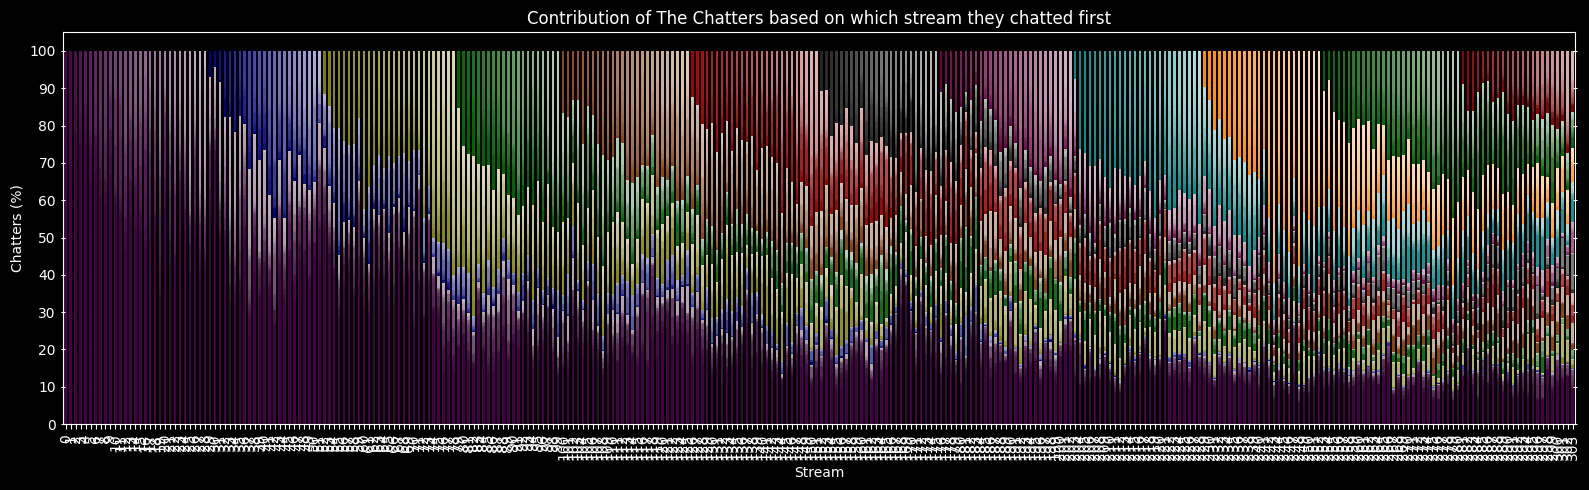

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the percentage data
plt.style.use('dark_background')
ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(16, 5), color=sorted_color_list, legend=False)

plt.title('Contribution of The Chatters based on which stream they chatted first')

# Adjust x and y labels
plt.xlabel('Stream', fontsize=10)  # Make x-axis label smaller
plt.ylabel('Chatters (%)')

# Adjust y-axis ticks to show every 10
plt.yticks(np.arange(0, 101, 10))  

# Show y-axis ticks on both left and right
ax.yaxis.set_ticks_position('both')  
ax.tick_params(axis='y', direction='inout')

plt.tight_layout()
plt.show()

In [29]:
pivot_table_percentage

first_stream,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,300,301,302,303
0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.107026,30.892974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,78.068264,7.407407,14.524328,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,75.284211,3.663158,4.336842,16.715789,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,75.030550,3.543788,4.154786,3.258656,14.012220,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,7.987650,1.551615,0.229576,0.000000,0.142495,0.577897,0.110830,1.725776,0.0,0.554148,...,1.527866,0.387904,0.237492,0.522483,2.865738,6.000633,0.000000,0.000000,0.000000,0.000000
300,9.865293,1.188590,0.726360,0.145272,0.052826,3.275225,0.000000,0.713154,0.0,0.884839,...,0.673534,0.105652,0.805600,0.647121,0.752773,0.699947,9.653988,0.000000,0.000000,0.000000
301,11.062083,1.026167,0.277065,0.030785,0.256542,0.297589,0.472037,1.056952,0.0,0.625962,...,0.472037,0.554130,0.749102,1.611083,0.810672,0.318112,1.652129,5.695228,0.000000,0.000000
302,12.616026,0.340974,0.056829,0.056829,0.094715,0.000000,0.094715,0.056829,0.0,1.363895,...,0.492518,0.530403,0.340974,0.644061,1.307066,0.284145,0.644061,3.049820,14.946013,0.000000


In [30]:
#pivot_table.to_excel('your_excel_file.xlsx', sheet_name='Pivot Table')